<a href="https://colab.research.google.com/github/Kalva014/HairHub/blob/main/Save_Hair_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load necessary libraries
import torch
import glob
import os
import numpy as np
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# Use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load the image you want to get hair from
image_path = '/content/drive/MyDrive/Hairhub_data/test_image.jpeg'

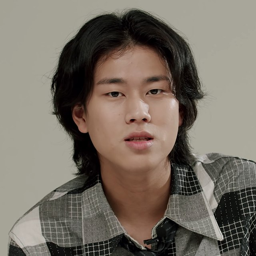

In [4]:
# Show the image
image = Image.open(image_path)
image = image.resize((256, 256))
image

In [5]:
# Convert image to np array
x = np.array(image)
x.shape

(256, 256, 3)

In [6]:
# The Segmentation Model
class UNet(torch.nn.Module):
    def __init__(self, input_channels, num_classes):
        super(UNet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes

        # Encoder
        self.conv1 = torch.nn.Conv2d(self.input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = torch.nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Middle
        self.conv9 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv10 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder
        self.up1 = torch.nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv11 = torch.nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        self.up2 = torch.nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv13 = torch.nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.up3 = torch.nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv15 = torch.nn.Conv2d(256, 128, kernel_size=3, padding=1)

        # Output
        self.out = torch.nn.Conv2d(128, self.num_classes, kernel_size=1)
        self.upsample = torch.nn.Upsample((256, 256), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x1 = torch.nn.functional.relu(self.conv1(x))
        x2 = torch.nn.functional.relu(self.conv2(x1))
        p1 = self.pool1(x2)

        x3 = torch.nn.functional.relu(self.conv3(p1))
        x4 = torch.nn.functional.relu(self.conv4(x3))
        p2 = self.pool2(x4)

        x5 = torch.nn.functional.relu(self.conv5(p2))
        x6 = torch.nn.functional.relu(self.conv6(x5))
        p3 = self.pool3(x6)

        x7 = torch.nn.functional.relu(self.conv7(p3))
        x8 = torch.nn.functional.relu(self.conv8(x7))
        p4 = self.pool4(x8)

        # Middle
        x9 = torch.nn.functional.relu(self.conv9(p4))
        x10 = torch.nn.functional.relu(self.conv10(x9))

        # Decoder
        x = self.up1(x10)
        x = torch.cat([x, x8], dim=1)
        x = torch.nn.functional.relu(self.conv11(x))

        x = self.up2(x)
        x = torch.cat([x, x6], dim=1)
        x = torch.nn.functional.relu(self.conv13(x))

        x = self.up3(x)
        x = torch.cat([x, x4], dim=1)
        x = torch.nn.functional.relu(self.conv15(x))

        # Output
        x = self.out(x)
        x = self.upsample(x)  # Upsample to match the original size

        return x


In [7]:
# Initialize the model
unet_model = UNet(input_channels=3, num_classes=1)
unet_model.to(device)

UNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv9): Conv2d(512, 1

In [8]:
# Load the entire model from the saved file
checkpoint = torch.load('/content/drive/MyDrive/Hairhub_data/unet_model.pth')

# Load the model state dictionary
unet_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
# Get image into the correct shape
x = x[np.newaxis, :]
x.shape

(1, 256, 256, 3)

In [10]:
# Generate the predicted output from the model
x = torch.from_numpy(x).float().permute(0, 3, 1, 2).to(device)
x.dtype

torch.float32

In [11]:
# Produce predicted mask
y_hat = unet_model(x)

In [47]:
# Limit the values to get the pixels
threshold = -0.8
# hair_mask = (y_hat[0, 0] >= threshold).to(torch.int)
hair_mask = (y_hat[0, 0] >= threshold).cpu().numpy()
print(hair_mask.shape)

(256, 256)


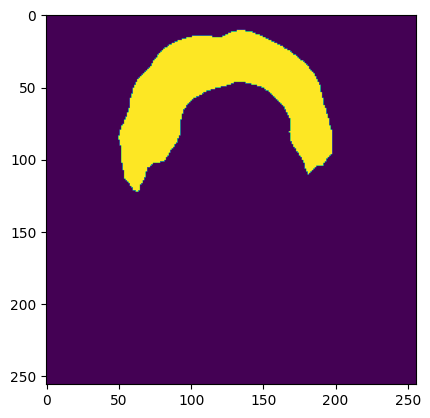

In [48]:
# Get the predictions for the 'hair' class
plt.imshow(hair_mask)
plt.show()

In [49]:
# Now output hair to its own separate image
segmented_image = np.array(image).copy()
segmented_image[~hair_mask] = 0

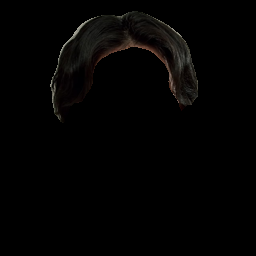

In [50]:
# Convert and display the result back to a PIL Image
segmented_image_pil = Image.fromarray(np.uint8(segmented_image))
segmented_image_pil

In [53]:
# Save the pil image
segmented_image_pil.save("/content/drive/MyDrive/Hairhub_data/hairstyles/hairstyle1.png")